# Scrape race data from web

In [145]:
from BeautifulSoup import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np

## 1. Functions to import and extract

In [146]:
def get_race_soup(year, race):
    if(year > 2017 or race > 5):
        print('Please use valid year and racenumber!')
        return 0

    url = "http://www.regentsparkraces.org/results.php?RaceYear="+str(year)+"&Race="+str(race)
    page_file = urllib2.urlopen(url)
    page_html = page_file.read()
    page_file.close()
    soup = BeautifulSoup("".join(page_html))
    
    return soup

In [180]:
def extract_results(soup):
    table = soup.find("table", { "class" : "ResultsTable" })
    header = 3
    # todo: check number of rows first.
    
    # run through table to fill dataframe
    for i, row in enumerate(table.findAll("tr")): 
        columns = row.findAll("td")
        if(i < header):
            continue
        elif(i == header):
            clmn = []
            for c in columns:
                clmn.append(c.getText())
            df = pd.DataFrame(columns = clmn, index =range(0,2000))
        else:
            for j,c in enumerate(columns):
                df.iat[i-header,j] = c.text.replace('&nbsp;', '')   
                           
    # some cleaning
    df = df.dropna(axis=0, how='all')
    
    # some columns should be ints
    for col in df:
        try:
            df[col] = df[col].astype(int)
        except ValueError:
            pass
    
    # remove incomplete races
    df = df[df['Place'] != 0]
    
    # set index to place in race
    df = df.set_index('Place')
    
    # for convenience, we convert times to (float) minutes
    # this a bit messy but robust.
    cols = ['Gun Time','Net Time','Lap 1 Time','Lap 2 Time','Lap 3 Time']
    
    for c in cols:
        df[c] = df[c].replace({'-': None})
        time = (df[c].str.split(':'))
        df[c] = ( 60.0     *time.str[0].values.astype(float)
                 +1.0      *time.str[1].values.astype(float)
                 +1.0/60.0 *time.str[2].values.astype(float)) 
    
    return df

## 2. Get all the data

In [187]:
# this will take a few minutes to run!

year = [2011,2012,2013,2014,2015,2016,2017]

for y in year:
    for r in range(0,6): # six races each year
        soup = get_race_soup(y,r)
        df = extract_results(soup)
        df.to_csv('data/y'+str(y)+'_r'+str(r), encoding='utf-8')

In [188]:
df.tail(3)

,Name,Bib No,Gun Time,Net Time,Category,Categ Pos,Gender,Gender Pos,Club,Lap 1 Time,Lap 2 Time,Lap 3 Time
Place,,,,,,,,,,,,
524,Teju Chosen,2867,105.350000,103.866667,LV45,27,Female,220,,36.250000,34.416667,34.633333
525,Gerard Hammond,1567,106.066667,85.316667,V50,39,Male,305,,46.783333,NaN,NaN
526,Ashilk Vahra,1528,106.066667,83.216667,V40,70,Male,306,,46.733333,29.200000,30.100000


In [189]:
df.dtypes

Name           object
Bib No          int64
Gun Time      float64
Net Time      float64
Category       object
Categ Pos       int64
Gender         object
Gender Pos      int64
Club           object
Lap 1 Time    float64
Lap 2 Time    float64
Lap 3 Time    float64
dtype: object

## 3. Quick look at the data

In [190]:
from matplotlib import pyplot as plt
%matplotlib inline

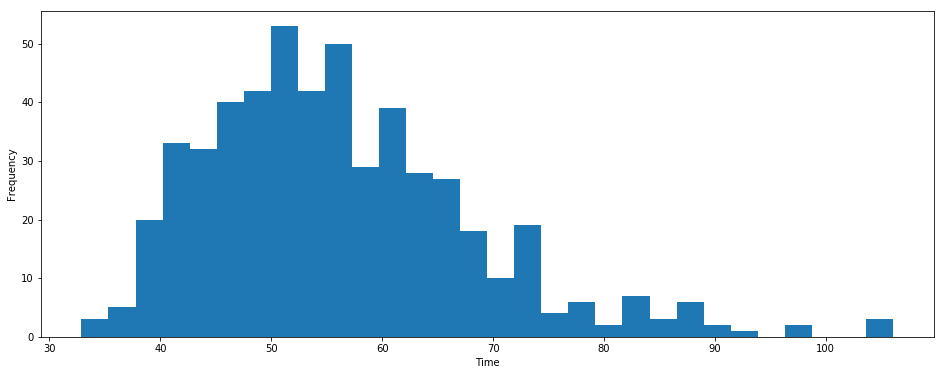

In [191]:
# Plot histogram of time
plt.figure(figsize=(16,6))
plt.grid(False)
df['Gun Time'].hist(bins=30,grid =False)
plt.xlabel('Time')
plt.ylabel('Frequency')

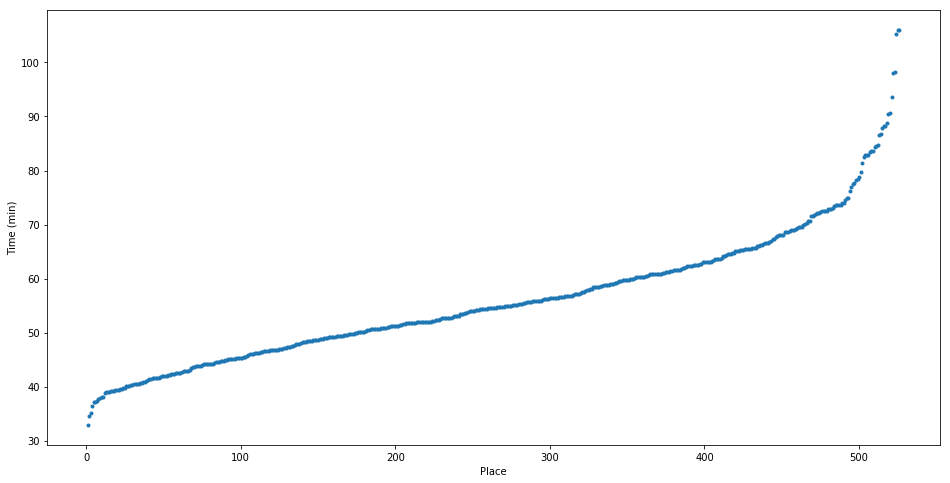

In [194]:
# Place vs time
df = df.reset_index()
plt.figure(figsize=(16,8))
plt.scatter(df['Place'], df['Gun Time'],marker='.')
plt.xlabel('Place')
plt.ylabel('Time (min)')